# Facial expression and Mood regression

Facial expressions dataset used from here: https://www.kaggle.com/ashishpatel26/facial-expression-recognitionferchallenge

In [ ]:
!pip install --upgrade torchinfo pytorch-ignite albumentations online_triplet_loss -qqq

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.models import resnet18, mobilenet
import torchinfo


from cv2 import cv2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [3]:
from google.colab import drive
drive.mount('/content/drive')
FER = '/content/drive/MyDrive/FER/'
!unzip {FER}icml_face_data.csv.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/FER/icml_face_data.csv.zip
replace icml_face_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# <span style="color: royalblue;">Load Data</span>
Load the image data with labels.

In [4]:
data = pd.read_csv('icml_face_data.csv')

In [5]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


# <span style="color: royalblue;">Functions</span>
We define some helper functions for preparing and ploting the data.

In [6]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

# <span style="color: royalblue;">Prepare Data</span> 

In [8]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

Define training, validation and test data:

In [9]:
train_image_array, train_image_label = prepare_data(data[data[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data[' Usage']=='PublicTest'])

Reshape and scale the images:

In [10]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

Encoding of the target value:

In [11]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

In [ ]:
plot_compare_distributions(train_labels, val_labels, title1='train labels', title2='val labels')

## FER PreTraining

In [13]:

class FERModel(nn.Module):

    def __init__(self, n_classes=7):
        super().__init__()
        self.net = mobilenet.MobileNetV2(1)
        self.reduction = nn.Linear(1280, 64, bias=False)
        self.reduction.weight.requires_grad = False
        self.output = nn.Linear(64, n_classes)

    def forward(self, x):
        x = self.embed(x)
        out = self.output(x)
        return out

    def embed(self, x):
        x = self.net.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).reshape(x.shape[0], -1)
        x = self.reduction(x)
        return x


In [ ]:
net = FERModel()
torchinfo.summary(net, input_size=(8, 3, 48, 48), depth=3)

torch.Size([32, 3, 48, 48])


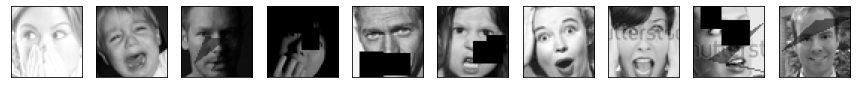

In [138]:
import albumentations as A
from albumentations.pytorch import transforms as AT
import albumentations.augmentations.transforms as AAT

class CustomDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, arrays, labels, transform=None):
        assert arrays.shape[0] == len(labels)
        self.arrays = arrays
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        x = self.arrays[index]
        if self.transform:
            x = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
            x = self.transform(image=x)['image']
        x = x.expand(3, -1, -1)
        y = self.labels[index]
        return x, y

    def __len__(self):
        return self.arrays.shape[0]
 

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(0.5, 0.5, p=0.5),
    A.OneOf([
        AAT.RandomShadow(shadow_roi=(0, 0, 1, 1), shadow_dimension=4),
        AAT.RandomSunFlare(flare_roi=(0, 0, 1, 1), num_flare_circles_lower=0, num_flare_circles_upper=2, src_radius=50),
    ]),
    A.CoarseDropout(max_holes=2, max_height=20, max_width=20, min_height=12, min_width=12),
    AT.ToTensor(),
])



test_transform = A.Compose([
    AT.ToTensor()
])



def get_data_loaders(train_batch_size, val_batch_size):
    trainset = CustomDataset(train_images, train_image_label, train_transform)
    valset = CustomDataset(test_images, test_image_label, test_transform)
    trainloader = DataLoader(trainset, train_batch_size, shuffle=True)
    valloader = DataLoader(valset, val_batch_size)
    return trainloader, valloader


def show_tensors(tensors, labels=None, n=10):
    for i in range(n):
        img = tensors[i].numpy()
        axs = plt.subplot(1, n, i+1)
        axs.imshow(img.transpose(1, 2, 0))
        axs.set(xticks=[], yticks=[])

        if labels is not None:
            axs.set_title(str(labels[i]))

    plt.gcf().set_size_inches(12, 8)
    plt.tight_layout()


train_loader, test_loader = get_data_loaders(32, 32)
batch = next(iter(train_loader))
print(batch[0].shape)
show_tensors(batch[0])
assert batch[0].dtype == torch.float32
assert batch[0].max() <= 1


### Train

In [ ]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine
from online_triplet_loss.losses import batch_hard_triplet_loss


# model = mobilenet.MobileNetV2(7).to(DEVICE)
model = FERModel(7).to(DEVICE)

train_loader, val_loader = get_data_loaders(64, 64)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.Adam (model.parameters(), lr=0.001)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.92)

criterion = nn.CrossEntropyLoss()

trainer = create_supervised_trainer(model, optimizer, criterion, device=DEVICE)

val_metrics = {
    "accuracy": Accuracy(),
    "nll": Loss(criterion)
}
train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)
valid_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

@trainer.on(Events.ITERATION_COMPLETED(every=100))
def log_training_loss(trainer):
    print(f"Epoch[{trainer.state.epoch}] Loss: {trainer.state.output:.3f}")


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    scheduler.step()
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    print(f"Training Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['nll']:.2f}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    valid_evaluator.run(val_loader)
    metrics = valid_evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch}  Avg accuracy: {metrics['accuracy']:.2f} Avg loss: {metrics['nll']:.2f}")


def score_function(engine):
    val_loss = engine.state.metrics['nll']
    return -val_loss


# checkpoint model
checkpointer = ModelCheckpoint('/content/', 'fer', n_saved=1, create_dir=True, score_function=score_function, require_empty=False)
valid_evaluator.add_event_handler(Events.COMPLETED, checkpointer, {'mymodel': model})

# early stopping
early_stopper = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
valid_evaluator.add_event_handler(Events.COMPLETED, early_stopper)

# start training
trainer.run(train_loader, max_epochs=30)

# load best checkpoint
model.load_state_dict(torch.load(checkpointer.last_checkpoint))
print('best score:', checkpointer.state_dict()['saved'][-1][0])


In [74]:
# save the model
# torch.save(model.state_dict(), '/content/drive/MyDrive/FER/fer_model.pt')

## Mood training

In [122]:
from cv2 import cv2
# load my images
myimages, mylabels = torch.load(FER + '/myimages.pt')
assert myimages[0].dtype == np.uint8
# mylabels
mylabels = np.clip(mylabels, -1, 1)  # clip -2s and 2s
mylabels = mylabels.astype('float32')


# make float, and resize to 48x48x1
myimages = np.stack([cv2.resize(img,(48, 48)).astype('float32')[:,:,None] / 255 for img in myimages])
assert myimages.shape[1:] == train_images.shape[1:]
assert myimages.dtype == train_images.dtype
assert mylabels.dtype == np.float32

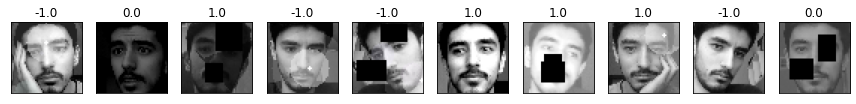

In [139]:
from sklearn.model_selection import train_test_split


def get_data_loaders(train_batch_size, val_batch_size, random_state = 0):
    trainX, testX, trainY, testY = train_test_split(myimages, mylabels, test_size=0.2, random_state=random_state)

    trainset = CustomDataset(trainX, trainY, train_transform)
    valset = CustomDataset(testX, testY, test_transform)
    trainloader = DataLoader(trainset, train_batch_size, shuffle=True)
    valloader = DataLoader(valset, val_batch_size)
    return trainloader, valloader

train_loader, val_loader = get_data_loaders(64, 128)
batch = next(iter(train_loader))
show_tensors(batch[0], batch[1].tolist())

(array([ 95.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0., 119.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

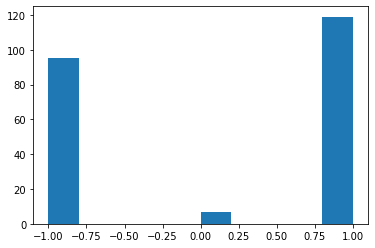

In [140]:
# distribution of label
import matplotlib.pyplot as plt

plt.hist(mylabels.tolist())

In [141]:

class MoodModel(nn.Module):
    def __init__(self, net: FERModel=None):
        super().__init__()
        if net is None:
            net = FERModel(7)
        self.net = net
        self.reduction = nn.Conv2d(1280, 16, 1, bias=False)
        self.reduction.weight.requires_grad = False
        self.output = nn.Linear(16, 1)
        self.drop = nn.Dropout()

    def forward(self, x):
        x = self.net.net.features(x)
        x = self.reduction(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1)).reshape(x.shape[0], -1)
        x = self.drop(x)
        x = self.output(x)
        return x


## Train

In [150]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.engine import Engine
from ignite.handlers import ModelCheckpoint, EarlyStopping

from online_triplet_loss.losses import batch_hard_triplet_loss


fer_model = FERModel(7)
fer_model.load_state_dict(torch.load(FER+'/fer_model.pt'))
model = MoodModel(fer_model).to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.3, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
criterion = nn.MSELoss()


def prepare_batch(batch, device, **kwargs):
    """Prepare batch for training: pass to a device with options.
    """
    x, y = batch
    x = x.to(device)
    y = y.to(device)

    y = y.unsqueeze(1)
    return x, y



trainer = create_supervised_trainer(model, optimizer, criterion, device=DEVICE, prepare_batch=prepare_batch)

val_metrics = {
    "mse": Loss(criterion)
}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE, prepare_batch=prepare_batch)


@trainer.on(Events.EPOCH_COMPLETED(every=10))
def log_training_results(trainer):
    scheduler.step()


@trainer.on(Events.EPOCH_COMPLETED(every=10))
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {trainer.state.epoch}  MSE: {metrics['mse']:.3f}")


def score_function(engine):
    val_loss = engine.state.metrics['mse']
    return -val_loss

# checkpoint model
checkpointer = ModelCheckpoint('/content/', 'myprefix', n_saved=1, create_dir=True, score_function=score_function, require_empty=False)
evaluator.add_event_handler(Events.COMPLETED, checkpointer, {'mymodel': model})

# early stopping
early_stopper = EarlyStopping(patience=15, score_function=score_function, trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, early_stopper)

trainer.run(train_loader, max_epochs=800)

# load best checkpoint
model.load_state_dict(torch.load(checkpointer.last_checkpoint))
print('best score:', checkpointer.state_dict()['saved'][-1][0])

Validation Results - Epoch: 10  MSE: 0.334
Validation Results - Epoch: 20  MSE: 0.171
Validation Results - Epoch: 30  MSE: 0.173
Validation Results - Epoch: 40  MSE: 0.104
Validation Results - Epoch: 50  MSE: 0.115
Validation Results - Epoch: 60  MSE: 0.111
Validation Results - Epoch: 70  MSE: 0.106
Validation Results - Epoch: 80  MSE: 0.111
Validation Results - Epoch: 90  MSE: 0.100
Validation Results - Epoch: 100  MSE: 0.113
Validation Results - Epoch: 110  MSE: 0.107
Validation Results - Epoch: 120  MSE: 0.102
Validation Results - Epoch: 130  MSE: 0.107
Validation Results - Epoch: 140  MSE: 0.095
Validation Results - Epoch: 150  MSE: 0.095
Validation Results - Epoch: 160  MSE: 0.103
Validation Results - Epoch: 170  MSE: 0.112
Validation Results - Epoch: 180  MSE: 0.101
Validation Results - Epoch: 190  MSE: 0.118
Validation Results - Epoch: 200  MSE: 0.110
Validation Results - Epoch: 210  MSE: 0.104
Validation Results - Epoch: 220  MSE: 0.108
Validation Results - Epoch: 230  MSE: 0.1

2021-04-09 21:00:11,822 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch: 290  MSE: 0.108
best score: -0.0949996100531684


In [154]:
# model.load_state_dict(torch.load('/content/myprefix_mymodel_-0.0851.pt'))
torch.save(model.state_dict(), FER+'/moodmodel.pt')

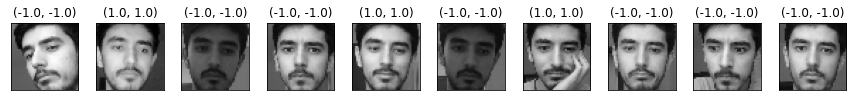

In [158]:
# look at some predictions
batch = next(iter(val_loader))
x, y = prepare_batch(batch, DEVICE)
with torch.no_grad():
    model.eval()
    predictions = model(x).cpu().flatten()
    predictions = torch.round(predictions)

show_tensors(batch[0], 
             list(zip(predictions.tolist(), batch[1].tolist())),
             n = 10
             )
plt.gcf().set_size_inches(12, 5)